<a href="https://colab.research.google.com/gist/IlKaiser/ae762f1fce37baabe00f113107740781/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Comment the following line to install dependencies
%%script echo skipping

import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 
!pip install pyvis

skipping


In [ ]:
# Basic Imports
import pandas as pd
import networkx as nx
from networkx.relabel import relabel_nodes
import numpy as np
from gensim.models import KeyedVectors


from os.path import exists

# Import All Gene Disease dataset

In [ ]:
df = pd.read_csv("all_gene_disease_associations.tsv", sep='\t', header=0)
df.head()

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.7,0.538,C0001418,Adenocarcinoma,group,C04,Neoplastic Process,0.01,1.0,2008.0,2008.0,1,0,LHGDN
1,1,A1BG,0.7,0.538,C0002736,Amyotrophic Lateral Sclerosis,disease,C18;C10,Disease or Syndrome,0.01,1.0,2008.0,2008.0,1,0,BEFREE
2,1,A1BG,0.7,0.538,C0003578,Apnea,phenotype,C23;C08,Sign or Symptom,0.01,1.0,2017.0,2017.0,1,0,BEFREE
3,1,A1BG,0.7,0.538,C0003864,Arthritis,disease,C05,Disease or Syndrome,0.01,1.0,2019.0,2019.0,1,0,BEFREE
4,1,A1BG,0.7,0.538,C0008373,Cholesteatoma,disease,C17,Disease or Syndrome,0.01,1.0,2020.0,2020.0,1,0,BEFREE


# Count most mentioned diseases
In this way I can decide to focus on some relevant disease

In [ ]:
# Show top 20 gene symbols per disease
df.groupby("diseaseName")["geneSymbol"].count()\
.reset_index(name='count')\
.sort_values(['count'], ascending=False)\
.head(20)

,diseaseName,count
20055,Neoplasms,10161
17952,Malignant Neoplasms,8621
23326,Primary malignant neoplasm,8221
18033,Malignant neoplasm of breast,6941
4604,Breast Carcinoma,6776
28471,Tumor Cell Invasion,6626
20027,Neoplasm Metastasis,6385
5519,Carcinogenesis,6243
16738,Liver carcinoma,5725
7057,Colorectal Carcinoma,5473


# Retrieve Information
Now it is necessary to retrieve information about genes for the chosen disease, in my case the **Liver carcinoma**

In [ ]:
# Get the gene list in order to label datas
gene_list = df[df["diseaseName"] == "Breast Carcinoma"]["geneSymbol"].drop_duplicates()
gene_list = list(gene_list)
print(len(gene_list))

6775


In [ ]:
# Display some genes
print(gene_list[:10])

['NAT1', 'NAT2', 'SERPINA3', 'AADAC', 'AAMP', 'AANAT', 'AARS1', 'ABCA1', 'ABCB7', 'ABCF1']


# Import Protein-Protein Interaction Dataset
Import the edge list as a graph

In [ ]:
ppi = nx.Graph()
edges = nx.read_edgelist("Biogrid_REDUX.txt")
ppi.add_edges_from(edges.edges())

ppi.remove_edges_from(nx.selfloop_edges(ppi))

In [ ]:
from pyvis.network import Network
from IPython.core.display import display, HTML

In [ ]:
display = False
if display:
  net = Network(notebook=True)
  net.from_nx(ppi)
  net.show("ppi.html")
  display(HTML('ppi.html'))

In [ ]:
print("# Nodes: "+str(len(ppi.nodes)))
print("# Edges: "+str(len(ppi.edges)))

# Nodes: 4263
# Edges: 8048


# Train machine learing model
With embeddings and labels it is now possible to train a machine learing model. I will try first with **SVM**

In [ ]:
# Sklearn imports
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler

# Torch imports 
import torch
from torch.autograd import Variable
from torch_geometric.data import Data
from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import Node2Vec
from torch_geometric.utils.convert import from_networkx
import torch.nn.functional as F

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

## Learn PPI embeddings
First we learn a node2vec model using torch geometric, then we label nodes with 0 or 1 if the protein is relevant for the chosen disease, according to the gene list previousely generated

In [ ]:
%%time
# Node 2 Vec nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

data = from_networkx(ppi)

model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
             context_size=10, walks_per_node=10,
             num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=128, shuffle=True, num_workers=2)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
 
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask],
                     max_iter=10)
    return acc


for epoch in tqdm(range(1, 101)):
    loss = train()
    #acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10, Loss: 1.2719
Epoch: 20, Loss: 0.9335
Epoch: 30, Loss: 0.8946
Epoch: 40, Loss: 0.8826
Epoch: 50, Loss: 0.8783
Epoch: 60, Loss: 0.8762
Epoch: 70, Loss: 0.8745
Epoch: 80, Loss: 0.8736
Epoch: 90, Loss: 0.8727
Epoch: 100, Loss: 0.8729
CPU times: user 2min, sys: 12.7 s, total: 2min 13s
Wall time: 2min 31s


In [ ]:
z = model()

In [ ]:
# from tensor to numpy
node_embeddings = z.detach().cpu().numpy()
print(node_embeddings)
print(node_embeddings.shape)

[[ 0.10941951  0.03950205  0.6213024  ...  0.06927338  0.15729974
   0.25325525]
 [ 0.16252516  0.17526999  0.61197495 ... -0.08406757  0.14174443
   0.22000356]
 [ 0.0025103  -0.03719484  0.3382452  ...  0.5491139   0.55974704
   0.02710002]
 ...
 [-0.00722818  0.05886897 -0.3203585  ...  0.22253644  0.14351444
   0.31511182]
 [ 0.03525304 -0.09281527  0.06796204 ... -0.01988691 -0.00296192
  -0.08897769]
 [-0.07752605 -0.1559043  -0.00813782 ... -0.22822411 -0.09419089
  -0.22492251]]
(4263, 128)


## Scale Embeddings
Scale the embeddings before training the model

In [ ]:
scaler = StandardScaler()
node_embeddings = scaler.fit_transform(node_embeddings)

In [ ]:
# Rename sets
X = node_embeddings

# Label nodes
Y = [1 if node in gene_list else 0 for node in ppi.nodes()]

print("Positive to total ratio: "+"{:.2f}".format( list(Y).count(1) / len(Y) *100) + "%")

Positive to total ratio: 46.19%


## Split the dataset for the first model
Split the dataset between train test and eval

In [ ]:
# Dataset split
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=1 - train_ratio, random_state = 42)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 42) 

# Training
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)

x_val = torch.FloatTensor(x_val)
y_val = torch.FloatTensor(y_val)

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

# Classifier model using MLP
We build a simple classifier feed-forward network on the base of a multi-layer perceptron

In [ ]:
class BinaryClassification(torch.nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = torch.nn.Linear(128, 256) 
        self.layer_2 = torch.nn.Linear(256, 256)
        self.layer_out = torch.nn.Linear(256, 1) 
        
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.1)
        self.batchnorm1 = torch.nn.BatchNorm1d(256)
        self.batchnorm2 = torch.nn.BatchNorm1d(256)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, training = self.training)
        x = self.layer_out(x)
        
        return x

# Start the training
We can now begin the training and evaluation of our MLP binary classifier


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_val   = x_val.to(device)
y_val   = y_val.to(device)
x_test  = x_test.to(device)
y_test  = y_test.to(device)

In [ ]:
model = BinaryClassification()

model = model.to(device)
print(model)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

BinaryClassification(
  (layer_1): Linear(in_features=128, out_features=256, bias=True)
  (layer_2): Linear(in_features=256, out_features=256, bias=True)
  (layer_out): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
model.eval()
y_pred = model(x_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

Test loss before training 0.703216552734375


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
loss_values = []
val_values = []
epoch = []
epochs = 25
for i in tqdm(range(epochs)):
    print("{:.2f}".format( i / (epochs-1) * 100) + "%",end='\r')
    epoch_acc = 0
    
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()

            optimizer.zero_grad()
            # Forward pass
            y_pred = model(x_train)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_train)
            loss_values.append(loss)
            acc = binary_acc(y_pred, y_train.unsqueeze(1))
            epoch_acc += acc.item()

            #print('Epoch {}: train loss: {} Acc: {}'.format(epoch, loss.item(),epoch_acc))
            # Backward pass
            loss.backward()
            optimizer.step()
            
            
        elif phase == 'val':
            model.eval()

            # Forward pass
            y_pred = model(x_val)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), y_val)
            val_values.append(loss)
            #print('Epoch {}: validation loss: {}'.format(epoch, loss.item()))
            optimizer.zero_grad()
        
            

  0%|          | 0/25 [00:00<?, ?it/s]

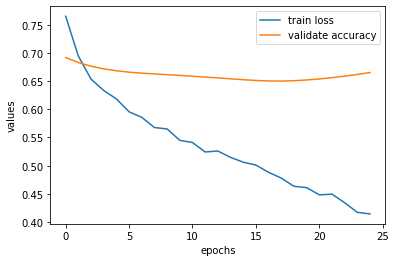

In [ ]:
plt.plot(loss_values,label='train loss')
plt.plot(val_values,label='validate accuracy')
plt.xlabel("epochs")
plt.ylabel("values")
plt.legend()
plt.show()

In [ ]:
model.eval()
y_pred = model(x_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.6794371604919434


In [ ]:
print(binary_acc(y_pred.squeeze(),y_test).item(),"%")

61.0 %


# Results
Display report after training

In [ ]:
# Stats imports
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
y_pred = torch.round(torch.sigmoid(y_pred.squeeze())).cpu().detach().numpy()

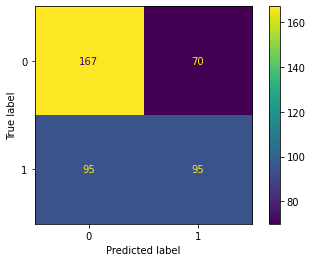

In [ ]:
cm = confusion_matrix(y_test.cpu(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test.cpu(), y_pred))

              precision    recall  f1-score   support

         0.0       0.64      0.70      0.67       237
         1.0       0.58      0.50      0.54       190

    accuracy                           0.61       427
   macro avg       0.61      0.60      0.60       427
weighted avg       0.61      0.61      0.61       427



# GNN model
Now we will proceed to create a GCN model in order to compare the results

In [ ]:
# GNN Imports
import torch.nn as nn
from torch_geometric.nn import GCNConv

In [ ]:
# Encode nx graph
adj = nx.to_scipy_sparse_matrix(ppi).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row,col],dim = 0)

In [ ]:
mapping = dict([(y,x) for x,y in enumerate(ppi.nodes())])
#print(mapping)
#print(ppi.nodes())
#print(Y)

## Generate Datset Class
Create the dataset class useful mainly for later applications

In [ ]:
# Dataset Class
class P2PDataset(InMemoryDataset):
    def __init__(self,transform = None):
        super(P2PDataset,self).__init__(".",transform,None,None)

        ppi_ = relabel_nodes(ppi, mapping, copy=True)

        data = Data(edge_index = edge_index)

        data.num_nodes = ppi_.number_of_nodes()
    
        data.x = torch.from_numpy(node_embeddings).type(torch.float32)

        y = torch.from_numpy(np.asarray(Y)).type(torch.long)

        data.y = y.clone().detach()

        data.num_classes = 2

        # train is now 75% of the entire data set
        # the _junk suffix means that we drop that variable completely
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(data.x), pd.Series(y), test_size=1 - train_ratio, random_state = 42)

        # test is now 10% of the initial data set
        # validation is now 15% of the initial data set
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state = 42) 

        train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        val_mask   = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask  = torch.zeros(data.num_nodes, dtype=torch.bool)
      
        train_mask[X_train.index] = True
        val_mask[X_val.index]     = True
        test_mask[X_test.index]   = True

        data["train_mask"] = train_mask
        data["val_mask"]   = val_mask
        data["test_mask"]  = test_mask

        self.data, self.slices = self.collate([data])
 

In [ ]:
p2p = P2PDataset()
data = p2p[0].to(device)
print(data)

Data(edge_index=[2, 16096], num_nodes=4263, x=[4263, 128], y=[4263], num_classes=2, train_mask=[4263], val_mask=[4263], test_mask=[4263])


In [ ]:
# GNN Class
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = GCNConv(p2p.num_features, 16)
    self.conv2 = GCNConv(16, p2p.num_classes)

  def forward(self,x,edge_index,edge_weights):
    x = F.relu(self.conv1(x,edge_index,edge_weights))
    x = F.dropout(x, training = self.training)
    x = self.conv2(x, edge_index,edge_weights)
    return F.log_softmax(x, dim=1)

In [ ]:
model = Net().to(device)
print(model)
lr = 1e-2

optimizer = torch.optim.Adam(model.parameters(),lr = lr) 
x, edge_index, edge_weight = data.x, data.edge_index, None

Net(
  (conv1): GCNConv(128, 16)
  (conv2): GCNConv(16, 2)
)


In [ ]:
@torch.no_grad()
def test():
  model.eval()
  logits = model(x,edge_index,edge_weight)

  test_mask = data["test_mask"]
  test_pred = logits[test_mask].max(1)[1]

  test_acc = test_pred.eq(data.y[test_mask]).sum().item()/ test_mask.sum().item()

  return test_acc 

In [ ]:
train_loss = []
val_values = []
for epoch in tqdm(range(25)):
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
      optimizer.zero_grad()
      log_logits = model(x, edge_index, edge_weight)

      loss = F.nll_loss(log_logits[data.train_mask], data.y[data.train_mask])
      train_loss.append(loss)
      loss.backward()
      optimizer.step()
    else:
      model.eval()
      optimizer.zero_grad()
      log_logits = model(x, edge_index, edge_weight)
      loss = F.nll_loss(log_logits[data.val_mask], data.y[data.val_mask])
      val_values.append(loss)
  
  logits = model(x,edge_index,edge_weight)
  train_mask = data["train_mask"]
  train_pred = logits[train_mask].max(1)[1]
  train_acc = train_pred.eq(data.y[train_mask]).sum().item()/ train_mask.sum().item()

  0%|          | 0/25 [00:00<?, ?it/s]

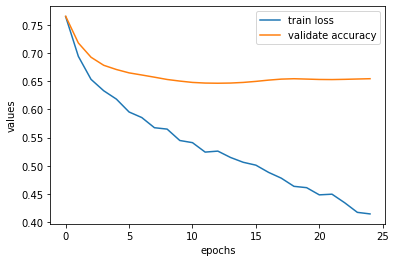

In [ ]:
plt.plot(loss_values,label='train loss')
plt.plot(val_values,label='validate accuracy')
plt.xlabel("epochs")
plt.ylabel("values")
plt.legend()
plt.show()

In [ ]:
test_acc = test()

In [ ]:
print("Train acc ", train_acc)
print("Test acc ", test_acc)

Train acc  0.6859555833593994
Test acc  0.6135831381733021


# GNN results
Display the GNN model results

In [ ]:
# Stats
logits = model(x,edge_index,edge_weight)
test_mask = data["test_mask"]
y_pred = logits[test_mask].max(1)[1]

In [ ]:
y_test_ = data.y[test_mask].cpu()

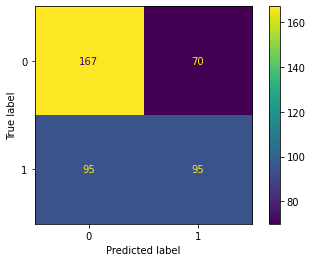

In [ ]:
cm = confusion_matrix(y_test_, y_pred.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test_, y_pred.cpu()))

              precision    recall  f1-score   support

           0       0.64      0.70      0.67       237
           1       0.58      0.50      0.54       190

    accuracy                           0.61       427
   macro avg       0.61      0.60      0.60       427
weighted avg       0.61      0.61      0.61       427



# Explainability
Now let's try to explain the resultant GNN model

In [ ]:
# Explainability imports
from torch_geometric.nn import GNNExplainer
import matplotlib.pyplot as plt

In [ ]:
with torch.no_grad():
  model.eval()
  logits = model(x,edge_index,edge_weight)
  preds = logits.max(1)[1]

In [ ]:
explainer = GNNExplainer(model, epochs = 200, return_type="log_prob", num_hops=2)

node_idx = 10
pred_node_idx = preds[node_idx].item()
print("Explaining node",node_idx,"with pred",pred_node_idx)

Explaining node 10 with pred 1


In [ ]:
node_feat_mask, edge_mask = explainer.explain_node(node_idx, x, edge_index, edge_weights=edge_weight)

Explain node 10: 100%|██████████| 200/200 [00:01<00:00, 138.23it/s]


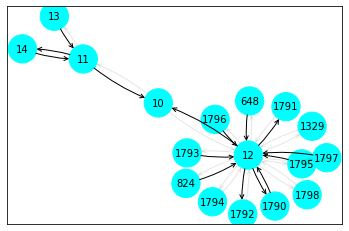

In [ ]:
ax, G = explainer.visualize_subgraph(node_idx, edge_index, edge_mask, seed = node_idx,threshold=0.5)